# **In Vehicle Coupon Recommendation 🚗**

This data was collected via a survey on Amazon Mechanical Turk. The survey describes different driving scenarios including the destination, current time, weather, passenger, etc., and then ask the person whether he will accept the coupon if he is the driver.



## **Problem Statement 🔍**
1. Determine the **effect of weather** on the acceptance of coupons. Which types of coupons are accepted in different weather conditions.

2. Determine how **demographic** (age, marital status, number of children and gender) affects the acceptance of coupons. Which coupons are accepted by different demographic groups?

3. Determine the **effect of income** on the acceptance of coupons. How does income affect the type of coupon accepted?

4. Determine the **effect of urgency and convenience** on the acceptance of coupons. How do coupon expiration time, distance, urgency by the driver and whether the establishment lies on the same side of the road affect the type of coupons accepted?

In [ ]:
!pip install xgboost

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

## **1. Data Preparation 💼**

### **Step 1:** Reading the CSV file

In [ ]:
# Step 1: Reading the CSV file
df = pd.read_csv("in-vehicle-coupon-recommendation.csv")
df.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


### **Step 2:** Getting some basic info about the data

In [ ]:
# Generate summary statistics
df.describe()     # We get some basic info about the data
# NOTE that this only gives info about columns with numeric values

,temperature,has_children,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
count,12684.000000,12684.000000,12684.0,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000
mean,63.301798,0.414144,1.0,0.561495,0.119126,0.214759,0.785241,0.568433
std,19.154486,0.492593,0.0,0.496224,0.323950,0.410671,0.410671,0.495314
min,30.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
50%,80.000000,0.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
75%,80.000000,1.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
max,80.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


### **Step 3:** Checking the data type of each column

In [ ]:
df.dtypes

destination             object
passanger               object
weather                 object
temperature              int64
time                    object
coupon                  object
expiration              object
gender                  object
age                     object
maritalStatus           object
has_children             int64
education               object
occupation              object
income                  object
car                     object
Bar                     object
CoffeeHouse             object
CarryAway               object
RestaurantLessThan20    object
Restaurant20To50        object
toCoupon_GEQ5min         int64
toCoupon_GEQ15min        int64
toCoupon_GEQ25min        int64
direction_same           int64
direction_opp            int64
Y                        int64
dtype: object

## **2. Data Cleaning 🧽**

### **Step 1:** Visualizing Missing Values and 'Dealing' with them

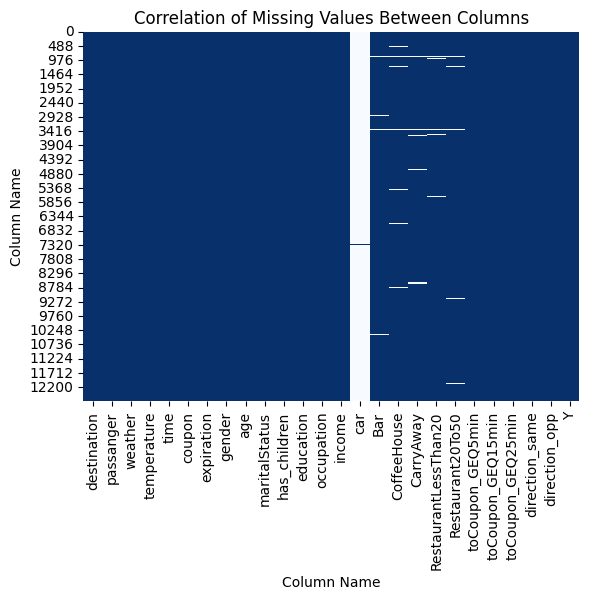

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
1237,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Male,26,Single,...,4~8,4~8,1~3,never,1,0,0,0,1,1
1238,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Male,26,Single,...,4~8,4~8,1~3,never,1,0,0,0,1,0
1239,No Urgent Place,Friend(s),Sunny,80,10AM,Bar,1d,Male,26,Single,...,4~8,4~8,1~3,never,1,0,0,0,1,1
1240,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Male,26,Single,...,4~8,4~8,1~3,never,1,1,0,0,1,0
1241,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Male,26,Single,...,4~8,4~8,1~3,never,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8293,Work,Alone,Rainy,55,7AM,Restaurant(<20),2h,Male,21,Single,...,less1,1~3,less1,less1,1,1,1,0,1,1
8294,Work,Alone,Rainy,55,7AM,Restaurant(20-50),1d,Male,21,Single,...,less1,1~3,less1,less1,1,1,1,0,1,1
8295,Work,Alone,Snowy,30,7AM,Restaurant(<20),2h,Male,21,Single,...,less1,1~3,less1,less1,1,1,1,0,1,1
8296,Work,Alone,Snowy,30,7AM,Restaurant(20-50),1d,Male,21,Single,...,less1,1~3,less1,less1,1,1,1,0,1,1


In [ ]:
# Create a correlation matrix of missing values

# Draw a heatmap of the correlation matrix
sns.heatmap(df.isna(), cbar=False, cmap="Blues_r")            # Blues_r is the colour scheme, c_bar=False hides the colour scale

# Set the chart title and labels
plt.title('Correlation of Missing Values Between Columns')
plt.xlabel('Column Name')
plt.ylabel('Column Name')

# Show the plot
plt.show()

# Dropping rows with NaN values
df.dropna()

As majority of missing values is in the `car` column, we will drop that column.

### **Step 2:** Remove columns which we will not be using, e.g. temperature, education, etc.

In [ ]:
columns_to_drop = ['temperature', 'education', 'car', 'CarryAway', 'occupation', 'CarryAway',
                   'RestaurantLessThan20', 'Restaurant20To50']            # Listing the columns to drop
df.drop(columns=columns_to_drop, inplace=True)                            # inplace=True makes sure that the change is reflected in the CSV file
df.head()

,destination,passanger,weather,time,coupon,expiration,gender,age,maritalStatus,has_children,income,Bar,CoffeeHouse,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,1,$37500 - $49999,never,never,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,10AM,Coffee House,2h,Female,21,Unmarried partner,1,$37500 - $49999,never,never,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,1,$37500 - $49999,never,never,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,2PM,Coffee House,2h,Female,21,Unmarried partner,1,$37500 - $49999,never,never,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,2PM,Coffee House,1d,Female,21,Unmarried partner,1,$37500 - $49999,never,never,1,1,0,0,1,0


### **Step 3:** Converting data in all the columns to numeric data

In [ ]:
# Converting destination column to numeric

df['destination'].unique()      # Getting all the unique values in destination

# Creating a dictionary mapping all the unique values in destination to numeric values
destination_mapping = {
    'No Urgent Place' : 0,
    'Home': 1,
    'Work': 2
}

df['destination'] = df['destination'].map(destination_mapping)
df.head()

,destination,passanger,weather,time,coupon,expiration,gender,age,maritalStatus,has_children,income,Bar,CoffeeHouse,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,0,Alone,Sunny,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,1,$37500 - $49999,never,never,1,0,0,0,1,1
1,0,Friend(s),Sunny,10AM,Coffee House,2h,Female,21,Unmarried partner,1,$37500 - $49999,never,never,1,0,0,0,1,0
2,0,Friend(s),Sunny,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,1,$37500 - $49999,never,never,1,1,0,0,1,1
3,0,Friend(s),Sunny,2PM,Coffee House,2h,Female,21,Unmarried partner,1,$37500 - $49999,never,never,1,1,0,0,1,0
4,0,Friend(s),Sunny,2PM,Coffee House,1d,Female,21,Unmarried partner,1,$37500 - $49999,never,never,1,1,0,0,1,0


In [ ]:
  #Convertion for passanger
df['passanger'].unique()          # Getting all the unique values in destination

# Creating a dictionary mapping all the unique values in passanger to numeric values
passanger_mapping = {
    'Alone' : 0, 'Friend(s)' : 1, 'Kid(s)' : 2, 'Partner' : 3
}

df['passanger'] = df['passanger'].map(passanger_mapping)
df['passanger'].head()

0    0
1    1
2    1
3    1
4    1
Name: passanger, dtype: int64

In [ ]:
#Time Converion


# Get all unique values in a time
unique_values_coupon = df['time'].unique()

# Print the unique values for coupon
print('Unique Values:')
for value in unique_values_coupon:
    print(value)


time_mapping = {
    '12AM': 0, '1AM': 1, '2AM': 2, '3AM': 3, '4AM': 4, '5AM': 5,
    '6AM': 6, '7AM': 7, '8AM': 8, '9AM': 9, '10AM': 10, '11AM': 11,
    '12PM': 12, '1PM': 13, '2PM': 14, '3PM': 15, '4PM': 16, '5PM': 17,
    '6PM': 18, '7PM': 19, '8PM': 20, '9PM': 21, '10PM': 22, '11PM': 23
}

# Convert the "time" column to numbers using the mapping
df['time'] = df['time'].map(time_mapping)

# Print the updated DataFrame
df  # Check the entire DataFrame to see if there are any NaN values

Unique Values:
2PM
10AM
6PM
7AM
10PM


,destination,passanger,weather,time,coupon,expiration,gender,age,maritalStatus,has_children,income,Bar,CoffeeHouse,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,0,0,Sunny,14,Restaurant(<20),1d,Female,21,Unmarried partner,1,$37500 - $49999,never,never,1,0,0,0,1,1
1,0,1,Sunny,10,Coffee House,2h,Female,21,Unmarried partner,1,$37500 - $49999,never,never,1,0,0,0,1,0
2,0,1,Sunny,10,Carry out & Take away,2h,Female,21,Unmarried partner,1,$37500 - $49999,never,never,1,1,0,0,1,1
3,0,1,Sunny,14,Coffee House,2h,Female,21,Unmarried partner,1,$37500 - $49999,never,never,1,1,0,0,1,0
4,0,1,Sunny,14,Coffee House,1d,Female,21,Unmarried partner,1,$37500 - $49999,never,never,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,1,3,Rainy,18,Carry out & Take away,1d,Male,26,Single,0,$75000 - $87499,never,never,1,0,0,1,0,1
12680,2,0,Rainy,7,Carry out & Take away,1d,Male,26,Single,0,$75000 - $87499,never,never,1,0,0,0,1,1
12681,2,0,Snowy,7,Coffee House,1d,Male,26,Single,0,$75000 - $87499,never,never,1,0,0,1,0,0
12682,2,0,Snowy,7,Bar,1d,Male,26,Single,0,$75000 - $87499,never,never,1,1,1,0,1,0


In [ ]:
#Coupon Conversion to Numeric Data

# Get all unique values in a coupon
unique_values_coupon = df['coupon'].unique()

# Print the unique values for coupon
print('Unique Values:')
for value in unique_values_coupon:
    print(value)

# Define a flag to keep track of whether conversion has been done
conversion_done = False

# Define a dictionary to map unique values to numeric values
coupon_mapping = {
    'Restaurant(<20)': 0,
    'Coffee House': 1,
    'Carry out & Take away': 2,
    'Bar': 3,
    'Restaurant(20-50)': 4
}

# Apply the mapping to the 'coupon' column
if not conversion_done:
    df['coupon'] = df['coupon'].map(coupon_mapping)
    conversion_done = True


# Print the updated DataFrame
df

Unique Values:
Restaurant(<20)
Coffee House
Carry out & Take away
Bar
Restaurant(20-50)


,destination,passanger,weather,time,coupon,expiration,gender,age,maritalStatus,has_children,income,Bar,CoffeeHouse,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,0,0,Sunny,14,0,1d,Female,21,Unmarried partner,1,$37500 - $49999,never,never,1,0,0,0,1,1
1,0,1,Sunny,10,1,2h,Female,21,Unmarried partner,1,$37500 - $49999,never,never,1,0,0,0,1,0
2,0,1,Sunny,10,2,2h,Female,21,Unmarried partner,1,$37500 - $49999,never,never,1,1,0,0,1,1
3,0,1,Sunny,14,1,2h,Female,21,Unmarried partner,1,$37500 - $49999,never,never,1,1,0,0,1,0
4,0,1,Sunny,14,1,1d,Female,21,Unmarried partner,1,$37500 - $49999,never,never,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,1,3,Rainy,18,2,1d,Male,26,Single,0,$75000 - $87499,never,never,1,0,0,1,0,1
12680,2,0,Rainy,7,2,1d,Male,26,Single,0,$75000 - $87499,never,never,1,0,0,0,1,1
12681,2,0,Snowy,7,1,1d,Male,26,Single,0,$75000 - $87499,never,never,1,0,0,1,0,0
12682,2,0,Snowy,7,3,1d,Male,26,Single,0,$75000 - $87499,never,never,1,1,1,0,1,0


In [ ]:
#Expiration Conversion

# Get all unique values in a expiration
unique_values_expiration = df['expiration'].unique()

# Print the unique values for coupon
print('Unique Values:')
for value in unique_values_expiration:
    print(value)

# Define a dictionary to map unique values to numeric values
expiration_mapping = {
    '1d': 24,
    '2h': 2
}

# Apply the mapping to the 'expiration' column
df['expiration'] = df['expiration'].map(expiration_mapping)

# Print the updated DataFrame
df

Unique Values:
1d
2h


,destination,passanger,weather,time,coupon,expiration,gender,age,maritalStatus,has_children,income,Bar,CoffeeHouse,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,0,0,Sunny,14,0,24,Female,21,Unmarried partner,1,$37500 - $49999,never,never,1,0,0,0,1,1
1,0,1,Sunny,10,1,2,Female,21,Unmarried partner,1,$37500 - $49999,never,never,1,0,0,0,1,0
2,0,1,Sunny,10,2,2,Female,21,Unmarried partner,1,$37500 - $49999,never,never,1,1,0,0,1,1
3,0,1,Sunny,14,1,2,Female,21,Unmarried partner,1,$37500 - $49999,never,never,1,1,0,0,1,0
4,0,1,Sunny,14,1,24,Female,21,Unmarried partner,1,$37500 - $49999,never,never,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,1,3,Rainy,18,2,24,Male,26,Single,0,$75000 - $87499,never,never,1,0,0,1,0,1
12680,2,0,Rainy,7,2,24,Male,26,Single,0,$75000 - $87499,never,never,1,0,0,0,1,1
12681,2,0,Snowy,7,1,24,Male,26,Single,0,$75000 - $87499,never,never,1,0,0,1,0,0
12682,2,0,Snowy,7,3,24,Male,26,Single,0,$75000 - $87499,never,never,1,1,1,0,1,0


In [ ]:
# Age Conversion
print(df['age'].unique())

age_mapping = {
    'below21': 0, '21': 1, '26': 2, '31': 3,
    '36': 4, '41': 5, '46' : 6, '50plus': 7,
}

# Apply the mapping to the 'age' column
df['age'] = df['age'].map(age_mapping)

# Dropping rows with age as NaN
df.dropna(subset=['age'])

df.head()

['21' '46' '26' '31' '41' '50plus' '36' 'below21']


,destination,passanger,weather,time,coupon,expiration,gender,age,maritalStatus,has_children,income,Bar,CoffeeHouse,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,0,0,Sunny,14,0,24,Female,1,Unmarried partner,1,$37500 - $49999,never,never,1,0,0,0,1,1
1,0,1,Sunny,10,1,2,Female,1,Unmarried partner,1,$37500 - $49999,never,never,1,0,0,0,1,0
2,0,1,Sunny,10,2,2,Female,1,Unmarried partner,1,$37500 - $49999,never,never,1,1,0,0,1,1
3,0,1,Sunny,14,1,2,Female,1,Unmarried partner,1,$37500 - $49999,never,never,1,1,0,0,1,0
4,0,1,Sunny,14,1,24,Female,1,Unmarried partner,1,$37500 - $49999,never,never,1,1,0,0,1,0


In [ ]:
##Convertion for gender
# Get all unique values in a gender
unique_values_gender = df['gender'].unique()

# Print the unique values for coupon
print('Unique Values:')
for value in unique_values_gender:
    print(value)

# Creating a dictionary mapping all the unique values in gender to numeric values
gender_mapping = {
    'Male' : 0,
    'Female': 1
}

df['gender'] = df['gender'].map(gender_mapping)
df.head()


Unique Values:
Female
Male


,destination,passanger,weather,time,coupon,expiration,gender,age,maritalStatus,has_children,income,Bar,CoffeeHouse,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,0,0,Sunny,14,0,24,1,1,Unmarried partner,1,$37500 - $49999,never,never,1,0,0,0,1,1
1,0,1,Sunny,10,1,2,1,1,Unmarried partner,1,$37500 - $49999,never,never,1,0,0,0,1,0
2,0,1,Sunny,10,2,2,1,1,Unmarried partner,1,$37500 - $49999,never,never,1,1,0,0,1,1
3,0,1,Sunny,14,1,2,1,1,Unmarried partner,1,$37500 - $49999,never,never,1,1,0,0,1,0
4,0,1,Sunny,14,1,24,1,1,Unmarried partner,1,$37500 - $49999,never,never,1,1,0,0,1,0


In [ ]:
#Conversion for income column

# Get all unique values in the income column
unique_values_income = df['income'].unique()

# Print the unique values
print('Unique Values:')
for value in unique_values_income:
    print(value)


# Creating a dictionary mapping all the unique values in income to numeric values
income_mapping = {
    'Less than $12500' : 0,
    '$12500 - $24999' : 1,
    '$25000 - $37499' : 2,
    '$37500 - $49999': 3,
    '$50000 - $62499' : 4,
    '$62500 - $74999' : 5,
    '$75000 - $87499' : 6,
    '$87500 - $99999' : 7,
    '$100000 or More' : 8
}

df['income'] = df['income'].map(income_mapping)
df.head()

Unique Values:
$37500 - $49999
$62500 - $74999
$12500 - $24999
$75000 - $87499
$50000 - $62499
$25000 - $37499
$100000 or More
$87500 - $99999
Less than $12500


,destination,passanger,weather,time,coupon,expiration,gender,age,maritalStatus,has_children,income,Bar,CoffeeHouse,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,0,0,Sunny,14,0,24,1,1,Unmarried partner,1,3,never,never,1,0,0,0,1,1
1,0,1,Sunny,10,1,2,1,1,Unmarried partner,1,3,never,never,1,0,0,0,1,0
2,0,1,Sunny,10,2,2,1,1,Unmarried partner,1,3,never,never,1,1,0,0,1,1
3,0,1,Sunny,14,1,2,1,1,Unmarried partner,1,3,never,never,1,1,0,0,1,0
4,0,1,Sunny,14,1,24,1,1,Unmarried partner,1,3,never,never,1,1,0,0,1,0


In [ ]:
#Conversion For Bar

# Get all unique values in the 'Bar' column
unique_values_bar = df['Bar'].unique()

# Print the unique values
print('Unique Values:')
for value in unique_values_bar:
    print(value)

#Dropping Nan values in the Bar column
# Drop rows with NaN values in column 'Bar'
df.dropna(subset=['Bar'], inplace=True)

# Creating a dictionary mapping all the unique values in income to numeric values
bar_mapping = {
    'never': 0,
   'less1' : 1,
    '1~3' : 2,
    '4~8': 3,
    'gt8' : 4

}

df['Bar'] = df['Bar'].map(bar_mapping)
df.head()

# Print a specific column
print(df['Bar'])

df.head()


Unique Values:
never
less1
1~3
gt8
nan
4~8
0        0
1        0
2        0
3        0
4        0
        ..
12679    0
12680    0
12681    0
12682    0
12683    0
Name: Bar, Length: 12577, dtype: int64


,destination,passanger,weather,time,coupon,expiration,gender,age,maritalStatus,has_children,income,Bar,CoffeeHouse,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,0,0,Sunny,14,0,24,1,1,Unmarried partner,1,3,0,never,1,0,0,0,1,1
1,0,1,Sunny,10,1,2,1,1,Unmarried partner,1,3,0,never,1,0,0,0,1,0
2,0,1,Sunny,10,2,2,1,1,Unmarried partner,1,3,0,never,1,1,0,0,1,1
3,0,1,Sunny,14,1,2,1,1,Unmarried partner,1,3,0,never,1,1,0,0,1,0
4,0,1,Sunny,14,1,24,1,1,Unmarried partner,1,3,0,never,1,1,0,0,1,0


In [ ]:
# Get all unique values in the 'CoffeeHouse' column
unique_values_coffeehouse = df['CoffeeHouse'].unique()

# Print the unique values
print('Unique Values:')
for value in unique_values_coffeehouse:
    print(value)


#Dropping Nan values in the CoffeeHouse column
# Drop rows with NaN values in column 'CoffeeHouse'
df.dropna(subset=['CoffeeHouse'], inplace=True)

# Creating a dictionary mapping all the unique values in coffeehouse to numeric values
coffeehouse_mapping = {
    'never': 0,
   'less1' : 1,
    '1~3' : 2,
    '4~8': 3,
    'gt8' : 4

}

df['CoffeeHouse'] = df['CoffeeHouse'].map(coffeehouse_mapping)
df.head()

Unique Values:
never
less1
4~8
1~3
gt8
nan


,destination,passanger,weather,time,coupon,expiration,gender,age,maritalStatus,has_children,income,Bar,CoffeeHouse,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,0,0,Sunny,14,0,24,1,1,Unmarried partner,1,3,0,0,1,0,0,0,1,1
1,0,1,Sunny,10,1,2,1,1,Unmarried partner,1,3,0,0,1,0,0,0,1,0
2,0,1,Sunny,10,2,2,1,1,Unmarried partner,1,3,0,0,1,1,0,0,1,1
3,0,1,Sunny,14,1,2,1,1,Unmarried partner,1,3,0,0,1,1,0,0,1,0
4,0,1,Sunny,14,1,24,1,1,Unmarried partner,1,3,0,0,1,1,0,0,1,0


In [ ]:
# Getting all the unique values in `maritalStatus`
df["maritalStatus"].unique()

# Creating a dictionary mapping all the unique values in coffeehouse to numeric values
marital_status_mapping = {
    "Unmarried partner" : 0, "Single" : 1, "Married partner" : 2,
    "Divorced" : 3, "Widowed" : 4
}

df["maritalStatus"] = df["maritalStatus"].map(marital_status_mapping)
df.head()

,destination,passanger,weather,time,coupon,expiration,gender,age,maritalStatus,has_children,income,Bar,CoffeeHouse,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,0,0,Sunny,14,0,24,1,1,0,1,3,0,0,1,0,0,0,1,1
1,0,1,Sunny,10,1,2,1,1,0,1,3,0,0,1,0,0,0,1,0
2,0,1,Sunny,10,2,2,1,1,0,1,3,0,0,1,1,0,0,1,1
3,0,1,Sunny,14,1,2,1,1,0,1,3,0,0,1,1,0,0,1,0
4,0,1,Sunny,14,1,24,1,1,0,1,3,0,0,1,1,0,0,1,0


In [ ]:
df["weather"].unique()

# Creating a dictionary mapping all the unique values in weather to numeric values
weather_mapping = {
    "Sunny" : 0, "Rainy" : 1, "Snowy" : 2
}

df["weather"] = df["weather"].map(weather_mapping)

df.head()

,destination,passanger,weather,time,coupon,expiration,gender,age,maritalStatus,has_children,income,Bar,CoffeeHouse,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,0,0,0,14,0,24,1,1,0,1,3,0,0,1,0,0,0,1,1
1,0,1,0,10,1,2,1,1,0,1,3,0,0,1,0,0,0,1,0
2,0,1,0,10,2,2,1,1,0,1,3,0,0,1,1,0,0,1,1
3,0,1,0,14,1,2,1,1,0,1,3,0,0,1,1,0,0,1,0
4,0,1,0,14,1,24,1,1,0,1,3,0,0,1,1,0,0,1,0


### **Step 4:** Removing Redundant columns:

Removing `direction_opp` column as `direction_same` column contains all the required info.


In [ ]:
df.drop(columns='direction_opp', inplace=True)
df.head()

,destination,passanger,weather,time,coupon,expiration,gender,age,maritalStatus,has_children,income,Bar,CoffeeHouse,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,Y
0,0,0,0,14,0,24,1,1,0,1,3,0,0,1,0,0,0,1
1,0,1,0,10,1,2,1,1,0,1,3,0,0,1,0,0,0,0
2,0,1,0,10,2,2,1,1,0,1,3,0,0,1,1,0,0,1
3,0,1,0,14,1,2,1,1,0,1,3,0,0,1,1,0,0,0
4,0,1,0,14,1,24,1,1,0,1,3,0,0,1,1,0,0,0


### **Step 5 :** Merging some columns to reduce the total number of dimensions
Merging `toCoupon_GEQ5min`, `toCoupon_GEQ15min` and `toCouponGEQ25min` into a new column `Distance`

In [ ]:
# Giving it value 2 where toCoupon_GEQ25min = 1, value 1 where toCoupon_GEQ15min = 1 and value 0 where toCouponGEQ5min = 1

# Creating a new column 'Distance'
df['Distance'] = np.where(df['toCoupon_GEQ25min'] == 1, 2,
                  np.where(df['toCoupon_GEQ15min'] == 1, 1,
                  np.where(df['toCoupon_GEQ5min'] == 1, 0, None))).astype(int)

# Reordering the columns to make Distance show up before Y
df = df[['destination', 'passanger', 'weather', 'time', 'coupon', 'expiration', 'gender', 'age', 'maritalStatus', 'has_children',
         'income', 'Bar', 'CoffeeHouse', 'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same', 'Distance', 'Y']]

df.head()

NameError: ignored

## **3. Data Visualization 📊**

We will use a diverse set of visualizations to better understand the data.

### **Plotting a pie chart to show the number of customers who were offered each type of coupon**

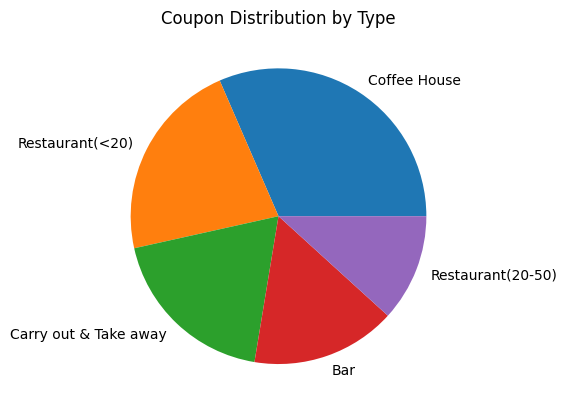

In [ ]:
# Extract keys (coupon types) and values (counts) from the Series
coupon_counts = df['coupon'].value_counts()
coupon_keys = coupon_counts.index.tolist()
coupon_values = coupon_counts.tolist()

# Create a label mapping dictionary
label_mapping = {
    0: 'Restaurant(<20)',
    1: 'Coffee House',
    2: 'Carry out & Take away',
    3: 'Bar',
    4: 'Restaurant(20-50)'
}

# Map the numeric values to their actual labels
xtick_labels = [label_mapping[key] for key in coupon_keys]

# Create a figure and axes object
fig, ax = plt.subplots()

# Plot the pie chart
ax.pie(coupon_values, labels=xtick_labels)

# Set the title
ax.set_title('Coupon Distribution by Type')

# Show the plot
plt.show()

So we can conclude
1. Coffeehouses have offered the most coupons
2. Restaurants with $20-50 avg spend have offered the least coupons

### **Plotting a bar chart to plot the % of coupons accepted by type**

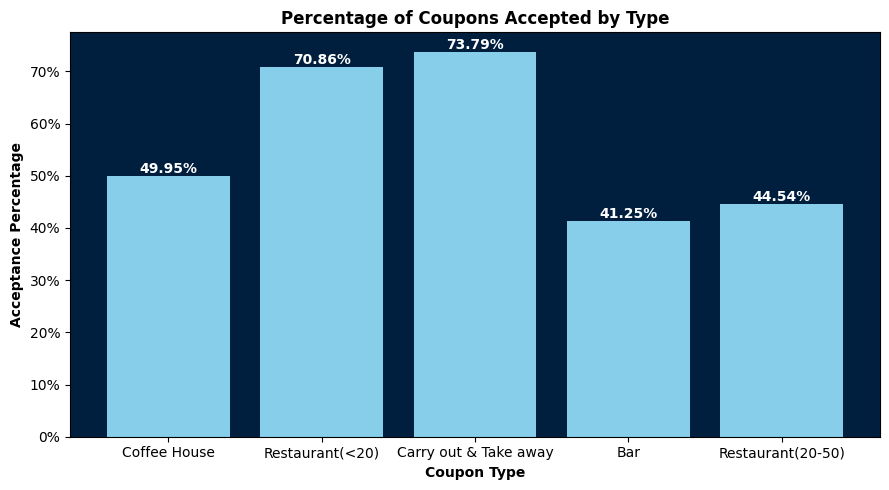

In [ ]:
from matplotlib.ticker import PercentFormatter  # Import PercentFormatter

# Calculate the percentage of coupons accepted by type
coupon_counts = df['coupon'].value_counts()
coupon_acceptance = df[df['Y'] == 1]['coupon'].value_counts() / coupon_counts

# Create a bar chart with a dark blue background
plt.figure(figsize=(9, 5))
bars = plt.bar(xtick_labels, coupon_acceptance, color='skyblue')
plt.title('Percentage of Coupons Accepted by Type', fontweight='bold')  # Bold title
plt.xlabel('Coupon Type', fontweight='bold')  # Bold x-axis label
plt.ylabel('Acceptance Percentage', fontweight='bold')  # Bold y-axis label
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))  # Format y-axis as a percentage

# Set the background color to dark blue
plt.gca().set_facecolor('#001f3f')

# Add percentage labels above each bar
for bar, percentage in zip(bars, coupon_acceptance):
    plt.text(bar.get_x() + bar.get_width() / 2, percentage, f"{percentage:.2%}",
             ha='center', va='bottom', fontsize=10, fontweight='bold', color="white")

plt.tight_layout()

plt.show()


So we can conclude that:
1. Carry out & Take away and Restaurants with <$20 average spend have high acceptance rates: >70%
2. All the other coupons have low acceptance rates: <50%

### **Plotting a heatmap to visualize coupon acceptance by weather**

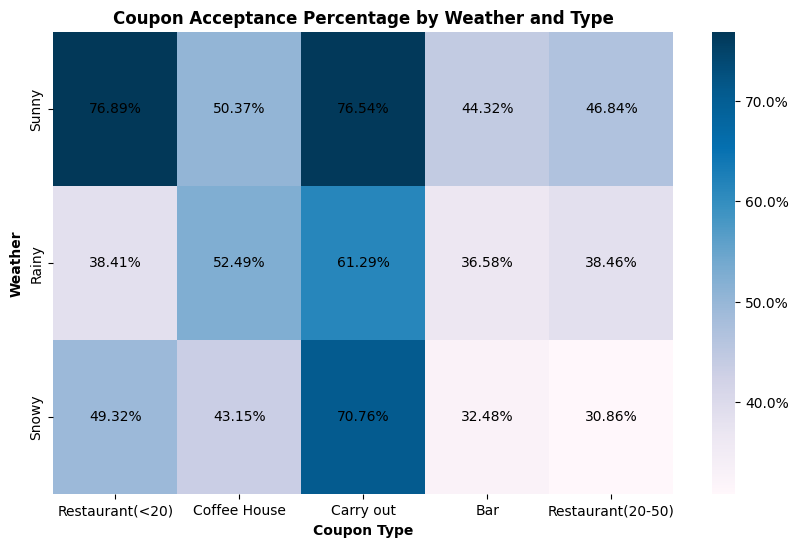

In [ ]:
# Create a pivot table for weather, coupon type, and acceptance percentage
heatmap_data = df.pivot_table(index='weather', columns='coupon', values='Y', aggfunc='mean')

# Create the heatmap with a darker color theme
plt.figure(figsize=(10, 6))
ax = sns.heatmap(heatmap_data, annot=True, cmap='PuBu', fmt=".2%", cbar_kws={'format': PercentFormatter(1)})

# Set darker text color for the annotation
for text in ax.texts:
    text.set_color('black')

plt.title('Coupon Acceptance Percentage by Weather and Type', fontweight='bold')
plt.xlabel('Coupon Type', fontweight='bold')
plt.ylabel('Weather', fontweight='bold')
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5], ['Restaurant(<20)', 'Coffee House', 'Carry out', 'Bar', 'Restaurant(20-50)'])
# Values in points as we want to centre it
plt.yticks([0.5, 1.5, 2.5], ['Sunny', 'Rainy', 'Snowy'])

plt.show()


We can draw a lot of conclusions from it. Some of them are:
1. Sunny weather is the best weather to offer coupons
2. Snowy weather is the worst weather to offer coupons
3. Coffeehouses perform the best in Rainy weather

### **Plotting a heatmap to visualize coupon acceptance by income**

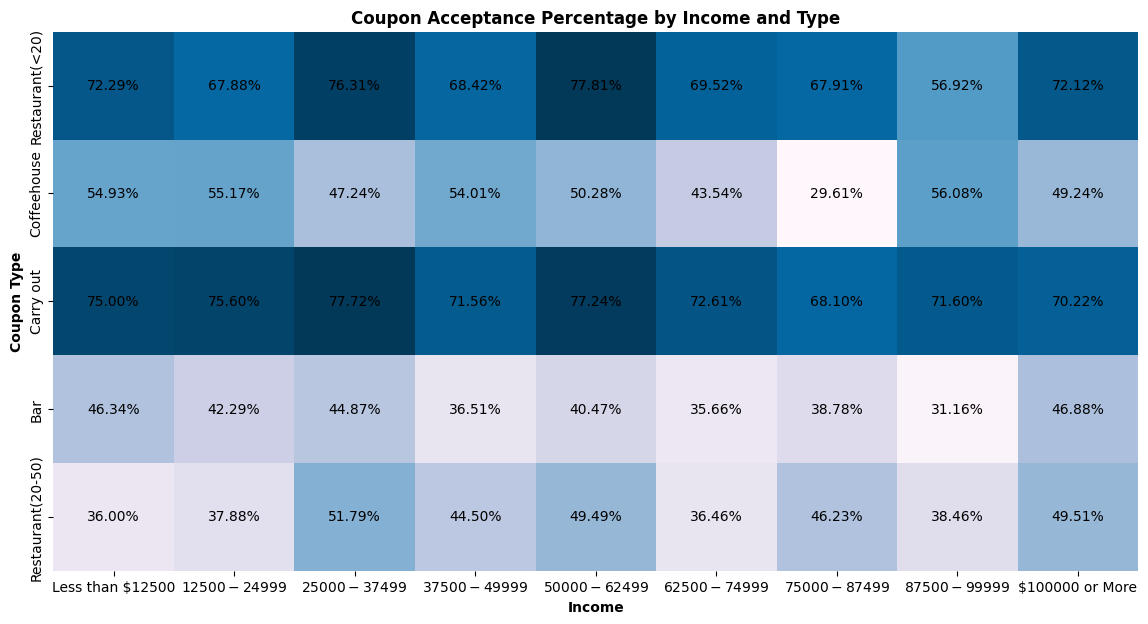

In [ ]:
# Create a pivot table for income, coupon type, and acceptance percentage
heatmap_data = df.pivot_table(index='coupon', columns='income', values='Y', aggfunc='mean')

# Create the heatmap with a darker color theme
plt.figure(figsize=(14, 7))
ax = sns.heatmap(heatmap_data, annot=True, cmap='PuBu', fmt=".2%", cbar_kws={'format': PercentFormatter(1)}, cbar=False)

# Set darker text color for the annotation
for text in ax.texts:
    text.set_color('black')

plt.title('Coupon Acceptance Percentage by Income and Type', fontweight='bold')
plt.xlabel('Income', fontweight='bold')
plt.ylabel('Coupon Type', fontweight='bold')
plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5], ['Restaurant(<20)', 'Coffeehouse', 'Carry out', 'Bar', 'Restaurant(20-50)'])     # Values in points as we want to centre it
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5],
 ['Less than $12500',
  '$12500 - $24999',
  '$25000 - $37499',
  '$37500 - $49999',
  '$50000 - $62499',
  '$62500 - $74999',
  '$75000 - $87499',
  '$87500 - $99999',
  '$100000 or More'])

plt.show()

We can draw a lot of conclusions from it. Some of them are:

1. Trend is noticed that Carry outs and Restaurants <20 are most prefered by customers within all ranges of income.

2. Extremely Low and High income customers prefer Bars more.

3. Restaurants ($20-$50) are more or less equally popular with middle-level income and high-level income customers.

### **Plotting a heatmap to visualize coupon acceptance by marital status**

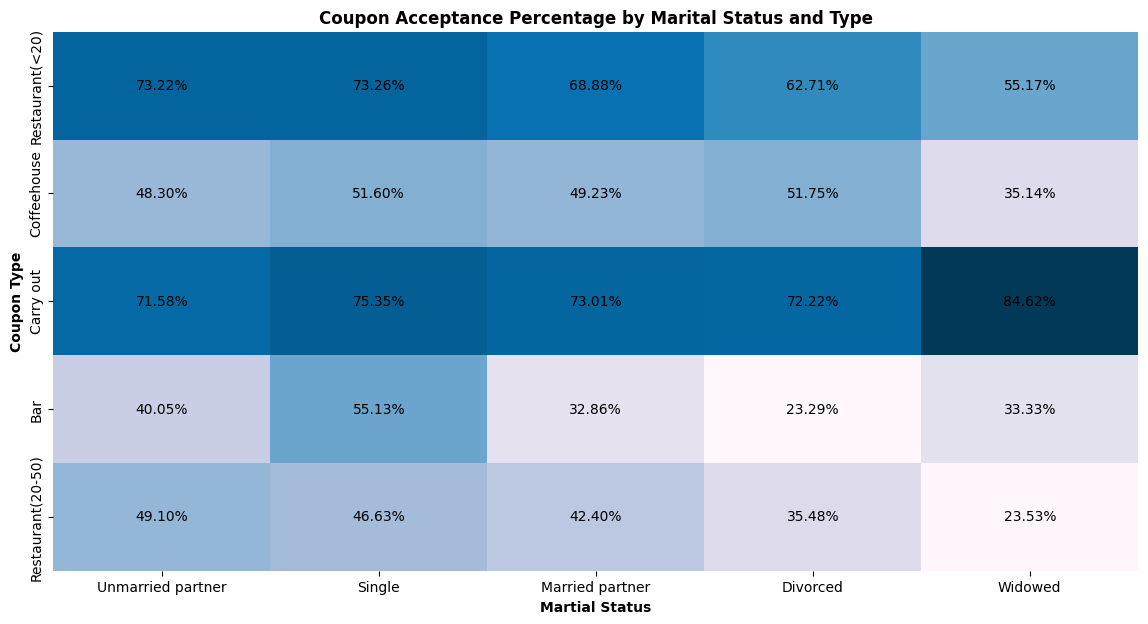

In [ ]:
# Create a pivot table for martial status, coupon type, and acceptance percentage

heatmap_data_marital_status = df.pivot_table(index='coupon', columns='maritalStatus', values='Y', aggfunc='mean')

# Create the heatmap with a darker color theme
plt.figure(figsize=(14, 7))
ax = sns.heatmap(heatmap_data_marital_status, annot=True, cmap='PuBu', fmt=".2%", cbar_kws={'format': PercentFormatter(1)}, cbar=False)

# Set darker text color for the annotation
for text in ax.texts:
    text.set_color('black')

plt.title('Coupon Acceptance Percentage by Marital Status and Type', fontweight='bold')
plt.xlabel('Martial Status', fontweight='bold')
plt.ylabel('Coupon Type', fontweight='bold')
plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5], ['Restaurant(<20)', 'Coffeehouse', 'Carry out', 'Bar', 'Restaurant(20-50)'])

# Change the x-axis labels without modifying the code input
ax.set_xticklabels(['Unmarried partner', 'Single', 'Married partner', 'Divorced', 'Widowed'])

plt.show()


We can draw a lot of conclusions from it. Some of them are:
1. Trend is noticed that Resturants<20 and Carry out is prefered by people of all martial status.
2. Windowed women most prefered coupon are carry out coupons.
3. Single and Unmarried People mainly prefer Bar and Restaurant(20-50) coupons.
4.  Except for customers who are windowed, Coffeehouses do fairly well.

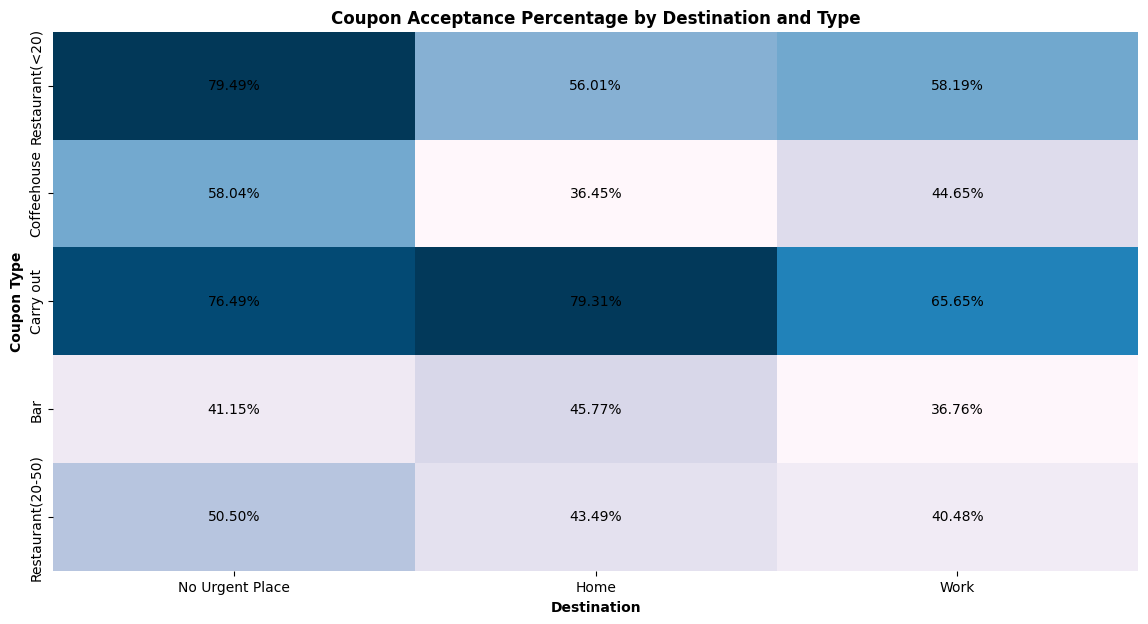

In [ ]:
# Create a pivot table for destination, coupon type, and acceptance percentage
heatmap_data_destination = df.pivot_table(index='coupon', columns='destination', values='Y', aggfunc='mean')

# Create the heatmap with a darker color theme
plt.figure(figsize=(14, 7))
ax = sns.heatmap(heatmap_data_destination, annot=True, cmap='PuBu', fmt=".2%", cbar_kws={'format': PercentFormatter(1)}, cbar=False)

# Set darker text color for the annotation
for text in ax.texts:
    text.set_color('black')

plt.title('Coupon Acceptance Percentage by Destination and Type', fontweight='bold')
plt.xlabel('Destination', fontweight='bold')
plt.ylabel('Coupon Type', fontweight='bold')
plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5], ['Restaurant(<20)', 'Coffeehouse', 'Carry out', 'Bar', 'Restaurant(20-50)'])

# Change the x-axis labels without modifying the code input
ax.set_xticklabels(['No Urgent Place', 'Home', 'Work'])

plt.show()


We can draw a lot of conclusions from it. Some of them are:
1. Trend is noticed that Resturants<20 and Carry out is prefered by people going to all destinations.
2.  Bar coupons are least prefered while going to work.
3. Coffee House and Restuarant(20-50) are most prefered by people who have no urgent place to go.

### **Plotting a grouped bar chart to visualize coupon acceptance by expiration time**

<ipython-input-74-ce2ea5215d4c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['acceptance_percentage'] = df.groupby(['coupon', 'expiration'])['Y'].transform('mean') * 100
<ipython-input-74-ce2ea5215d4c>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0f}%'.format(y) for y in ax.get_yticks()])


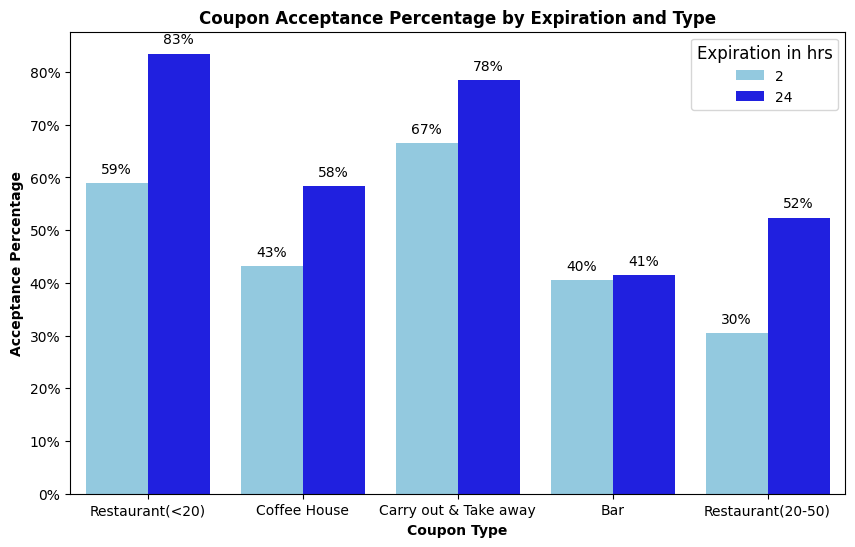

In [ ]:
# Calculate coupon acceptance percentage
df['acceptance_percentage'] = df.groupby(['coupon', 'expiration'])['Y'].transform('mean') * 100
# Filter the data for coupons with expiration equal to 2 and 24
two_hour_data = df[df['expiration'] == 2]
one_day_data = df[df['expiration'] == 24]
# Combine the data for the paired bar plot
combined_data = pd.concat([two_hour_data, one_day_data])
# Create a custom color palette with integer keys
custom_palette = {2: 'skyblue', 24: 'blue'}
plt.figure(figsize=(10, 6))
# Create a paired bar plot
ax = sns.barplot(x='coupon', y='acceptance_percentage', hue='expiration', data=combined_data, palette=custom_palette)
plt.title('Coupon Acceptance Percentage by Expiration and Type', fontweight='bold')
plt.xlabel('Coupon Type', fontweight='bold')
plt.ylabel('Acceptance Percentage', fontweight='bold')
ax.set_yticklabels(['{:,.0f}%'.format(y) for y in ax.get_yticks()])
# Show the legend
plt.legend(title='Expiration in hrs', title_fontsize='12', loc='upper right')
# Add percentages at the top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 10),
                textcoords='offset points')
# Map coupon numbers back to names
coupon_mapping = {
    0: 'Restaurant(<20)',
    1: 'Coffee House',
    2: 'Carry out & Take away',
    3: 'Bar',
    4: 'Restaurant(20-50)'
}
# Set x-axis labels
ax.set_xticklabels([coupon_mapping[int(label.get_text())] for label in ax.get_xticklabels()])
plt.show()

We can draw some interesting conclusions from this:
1. Normally, the coupons acceptance % increases if the expiry is of 1 day instead of 2 hours.
2. An anomaly here are bars, where coupon acceptance % are similar for 2hrs and 1 day.
3. Restaurants see a massive rise in acceptance % when the coupons expire in 1 day, as compared to 2 hours.

### **Plotting a grouped bar chart to visualize coupon acceptance by children**

<ipython-input-75-46ffeddea24f>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0f}%'.format(y) for y in ax.get_yticks()])


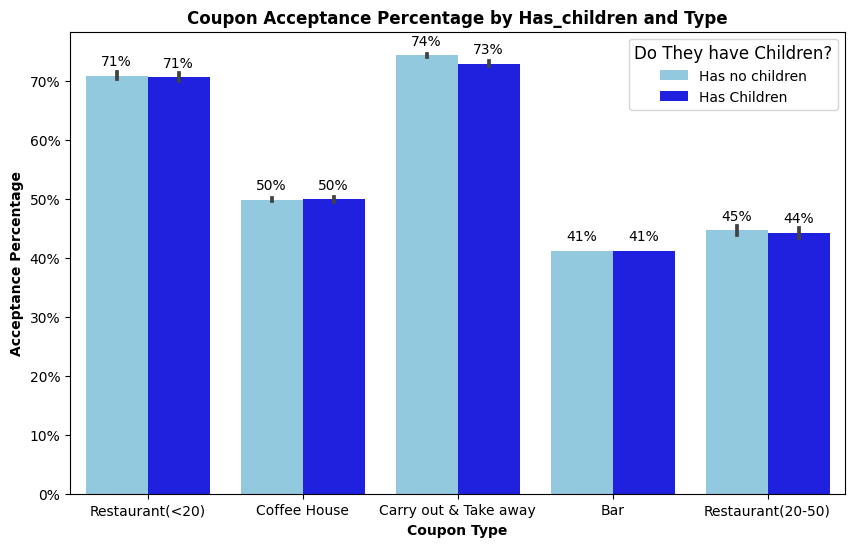

In [ ]:
# Create a custom color palette with integer keys
custom_palette = {0: 'skyblue', 1: 'blue'}

plt.figure(figsize=(10, 6))

# Create a paired bar plot
ax = sns.barplot(x='coupon', y='acceptance_percentage', hue='has_children', data=combined_data, palette=custom_palette)
plt.title('Coupon Acceptance Percentage by Children and Type', fontweight='bold')
plt.xlabel('Coupon Type', fontweight='bold')
plt.ylabel('Acceptance Percentage', fontweight='bold')
ax.set_yticklabels(['{:,.0f}%'.format(y) for y in ax.get_yticks()])

# Set custom legend labels
legend_labels = {0: 'Has no children', 1: 'Has Children'}
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=[legend_labels[int(label.get_text())] for label in ax.get_legend().get_texts()],
          title='Do They have Children?', title_fontsize='12', loc='upper right')
# Add percentages at the top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 10),
                textcoords='offset points')

# Map coupon numbers back to names
coupon_mapping = {
    0: 'Restaurant(<20)',
    1: 'Coffee House',
    2: 'Carry out & Take away',
    3: 'Bar',
    4: 'Restaurant(20-50)'
}
# Set x-axis labels
ax.set_xticklabels([coupon_mapping[int(label.get_text())] for label in ax.get_xticklabels()])
plt.show()


We can draw a lot of conclusions from it. Some of them are:
1.  Bars and Expensive restuarants are most prefered by customers without children rather than those with children
2. Other coupons are preferred by customers with and without children.

3. Resturant <20 and Carry Out by customers with both with and without children.  

## **4. Predictions using Machine Learning 🤖**

We will use XGBoost to predict which coupons will and will not be accepted

## Binary Classification
Checking if the coupon will be accepted or not

### **Step 1:** Dividing the features so that X contains independent variables and Y contains the dependent variable

In [ ]:
# Assigning the X and Y values for applying XGBoost
X=df.drop(columns=['Y'])
y=df['Y']
X.head()

,destination,passanger,weather,time,coupon,expiration,gender,age,maritalStatus,has_children,income,Bar,CoffeeHouse,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,Distance,acceptance_percentage
0,0,0,0,14,0,24,1,1,0,1,3,0,0,1,0,0,0,0,83.484163
1,0,1,0,10,1,2,1,1,0,1,3,0,0,1,0,0,0,0,43.238270
2,0,1,0,10,2,2,1,1,0,1,3,0,0,1,1,0,0,1,66.557377
3,0,1,0,14,1,2,1,1,0,1,3,0,0,1,1,0,0,1,43.238270
4,0,1,0,14,1,24,1,1,0,1,3,0,0,1,1,0,0,1,58.362168


### **Step 2:** Splitting the data into 2 parts:
* **Training:** To train the AI model
* **Testing:** To test the accuracy of the AI model

In [ ]:
# Splitting into training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=95)

### **Step 3:** Making predictions
Using XGBoost model to make predictions about whether the coupon will be accepted or not.

In [ ]:
# Creating an XGBoost model to train on the data
model = xgb.XGBClassifier(n_estimators=85, learning_rate=0.3, objective='binary:logistic', min_child_weight=1, subsample=1, max_depth=6)
model.fit(X_train, y_train)

# Making predictions on the data
y_pred = model.predict(X_test)

In [ ]:
# Evaluating performance
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)

# Calculate the accuracy in percentage
accuracy_percentage = accuracy * 100

print(f"Accuracy: {accuracy_percentage:.2f}%")           # An accuracy of 100 shows that all the predictions are correct

Accuracy: 76.94%
